# SCAM Detective

## 1. Importing modules and functions       
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import _pickle as cPickle
import gzip
import bz2

from calc_AD import *
from generate_maps import *
from matplotlib import cm

from rdkit import DataStructs
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances

def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
#%reload_ext autoreload
#%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

RDKit WARNING: [15:42:13] Enabling RDKit 2019.09.3 jupyter extensions


## Data entry

1. SDF
2. SMILES

In [2]:
# Set file path and format
file = 'example.sdf'
mol_input = 1

# Read SDF
if mol_input == 1:
    sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
    moldf = PandasTools.LoadSDF(file, **sdfInfo)
    print('Original data: ', moldf.shape)
    # Rename ROMol
    moldf = moldf.rename(columns={'ROMol': 'Mol'})
    # Remove missing RDKit molecules
    moldf = moldf[pd.notnull(moldf['Mol'])]
    if 'StandardizerResult' in moldf.columns:
        moldf = moldf.drop(columns='StandardizerResult')
    # Columns
    print('Kept data: ', moldf.shape)

    
# Read txt or CSV 
elif mol_input == 2:
    moldf = pd.read_csv(file, sep='\t', encoding='utf-8')
    # Add Mol column
    PandasTools.AddMoleculeColumnToFrame(moldf, smilesCol='SMILES', molCol='Mol', includeFingerprints=False)
    # Remove missing RDKit molecules
    moldf = moldf[pd.notnull(moldf['Mol'])]
    # Columns
    print(moldf.shape)

from molvs.validate import Validator
fmt = '%(asctime)s - %(levelname)s - %(validation)s - %(message)s'
validator = Validator(log_format=fmt)
print('\n Problematic structures: \n', validator.validate(moldf))

Original data:  (5, 4)
Kept data:  (5, 4)

 Problematic structures: 
 []


,InChIKey,SMILES,ID,Mol
0,WZXRSGMXJJLRNL-UHFFFAOYSA-N,Cc1cc(NC(=O)CCCSc2nc(-c3ccco3)cc(C(F)(F)F)n2)no1,,

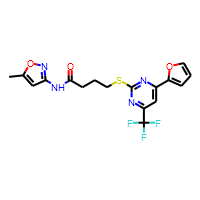

In [3]:
moldf.head(1)

## Descriptor calculation

In [4]:
def calcfp(mol,funcFPInfo=dict(radius=3,nBits=2048,useFeatures=False,useChirality = False)):
    arr = np.zeros((1,))
    fp = GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

moldf['Descriptors'] = moldf.Mol.apply(calcfp)
X = np.array(list(moldf['Descriptors'])).astype(int)
X.shape

(5, 2048)

## Predict SCAMs

### Load SCAM models

In [5]:
print('Loading models... \n')
with gzip.open('models/beta-lactamase/model_agg_RF_Morgan_balanced_v4.pkl.gz', 'rb') as f:
    beta_lactamase_model = cPickle.load(f)
    
with bz2.BZ2File('models/beta-lactamase/model_agg_RF_Morgan_balanced_v4.pkl.pbz2', 'rb') as f:
    beta_lactamase_model_data = cPickle.load(f)
beta_lactamase_model_fps = np.vstack(beta_lactamase_model_data['fpDF']['FingerPrint'].values)
beta_lactamase_model_AD_limit = (np.average(beta_lactamase_model_data['applM'])-(1*(np.std(beta_lactamase_model_data['applM']))))
print('Beta lactamase model loaded.')
del beta_lactamase_model_data

with gzip.open('models/cruzain/cruzain_agg_RF_Morgan_balanced_v4.pkl.gz', 'rb') as f:
    cruzain_model = cPickle.load(f)
    
with bz2.BZ2File('models/cruzain/cruzain_model_agg_RF_Morgan_balanced_v4.pbz2', 'rb') as f:
    cruzain_model_data = cPickle.load(f)
cruzain_model_fps = np.vstack(cruzain_model_data['fpDF']['FingerPrint'].values)
cruzain_model_AD_limit = (np.average(cruzain_model_data['applM'])-(1*(np.std(cruzain_model_data['applM']))))
print('Cruzain model loaded.')
del cruzain_model_data

Loading models... 

Beta lactamase model loaded.
Cruzain model loaded.


### Make predictions

In [6]:
print('Predicting SCAMs...')
y_pred_beta = beta_lactamase_model.predict(X)
y_pred_cruzain = cruzain_model.predict(X)

Predicting SCAMs...


In [7]:
print('Estimating applicability domain...')
calc_AD_beta = np.apply_along_axis(calc_AD, 1, X, beta_lactamase_model_fps, beta_lactamase_model_AD_limit)
calc_AD_cruzain = np.apply_along_axis(calc_AD, 1, X, cruzain_model_fps, cruzain_model_AD_limit)

# Beta-lactamase applicability domain
pred_beta = pd.DataFrame({'beta_lactamase': y_pred_beta,'beta_AD': calc_AD_beta}, index=None)
pred_beta.beta_AD[pred_beta.beta_AD == False] = np.nan
pred_beta.beta_AD[pred_beta.beta_AD == True] = pred_beta.beta_lactamase.astype(int)
pred_beta_ad = pred_beta.drop(pred_beta[pred_beta['beta_AD'] == 'Outside AD'].index).reset_index(drop=True)
coverage_ad = len(pred_beta_ad) * 100 / len(pred_beta)

# Cruzain applicability domain
pred_cruzain = pd.DataFrame({'cruzain': y_pred_cruzain,'cruzain_AD': calc_AD_cruzain}, index=None)
pred_cruzain.cruzain_AD[pred_cruzain.cruzain_AD == False] = np.nan
pred_cruzain.cruzain_AD[pred_cruzain.cruzain_AD == True] = pred_cruzain.cruzain.astype(int)
pred_cruzain_ad = pred_cruzain.drop(pred_cruzain[pred_cruzain['cruzain_AD'] == 'Outside AD'].index).reset_index(drop=True)
coverage_ad = len(pred_cruzain_ad) * 100 / len(pred_cruzain)

Estimating applicability domain...


### Export predictions

,InChIKey,SMILES,ID,Mol,beta_lactamase,beta_AD,cruzain,cruzain_AD
0,WZXRSGMXJJLRNL-UHFFFAOYSA-N,Cc1cc(NC(=O)CCCSc2nc(-c3ccco3)cc(C(F)(F)F)n2)no1,,,1,Inside AD,1,Inside AD
1,NGMGFRRMBXLNNS-UHFFFAOYSA-N,Cc1ccc(CSc2nc3ccncc3n2CC(=O)Nc2cc(C)cc(C)c2)cc1,,,1,Inside AD,1,Inside AD
2,NWUXAQZDESOKKL-MFKUBSTISA-N,COc1ccc(Br)cc1/C=N/NC(=O)c1nc(-c2ccccc2)n2c1CC...,,,1,Inside AD,1,Inside AD
3,NIJNUARVFJGCOA-UHFFFAOYNA-N,C=CCOc1cccc(C2c3c(oc4ccccc4c3=O)C(=O)N2c2ccccn...,,,0,Inside AD,0,Inside AD
4,FOYOYADXADLUCK-UHFFFAOYNA-N,O=C1OCCN1C(=O)C1C(c2ccccc2)C(c2cccc(Cl)c2)=NN1...,,,1,Outside AD,1,Inside AD

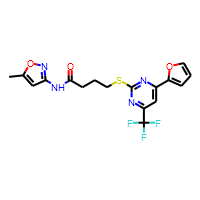
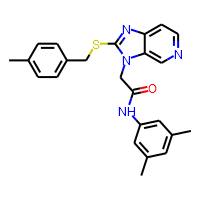
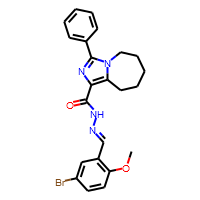
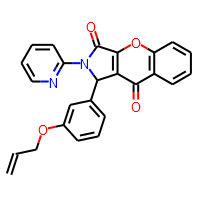
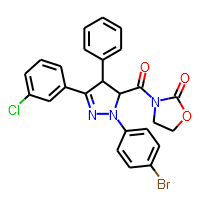

In [8]:
predictions = pd.concat([moldf, pred_beta, pred_cruzain], axis=1)
predictions.drop(columns='Descriptors', inplace=True)
predictions.head()

In [9]:
PandasTools.WriteSDF(predictions, 'predictions.sdf',
                     molColName='Mol', properties=list(predictions.columns))

## Generate maps of fragment contribution

Generating maps with predicted fragment contribution for beta-lactamase...


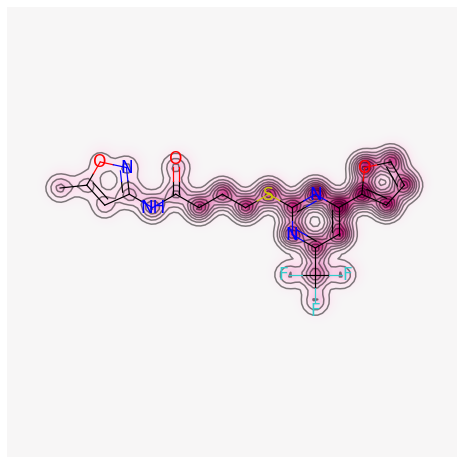

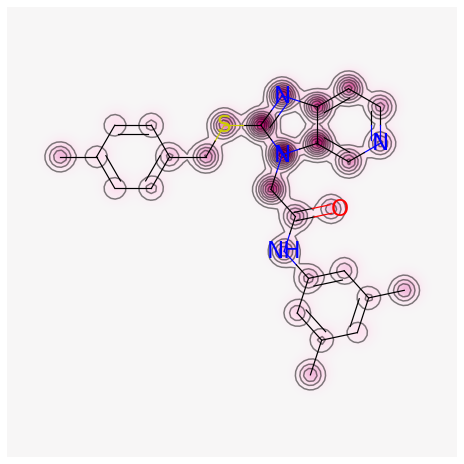

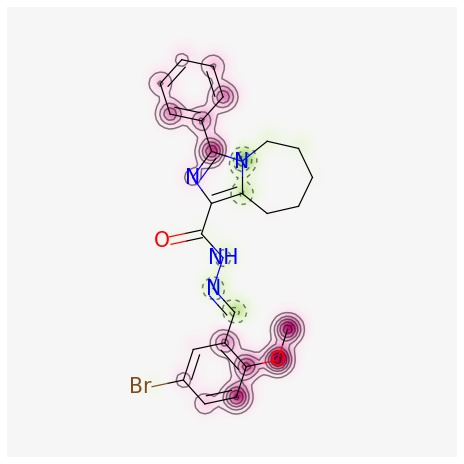

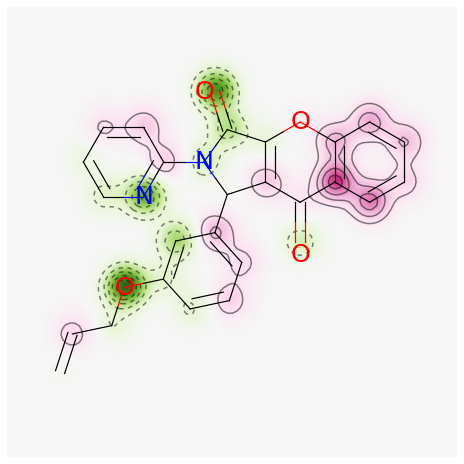

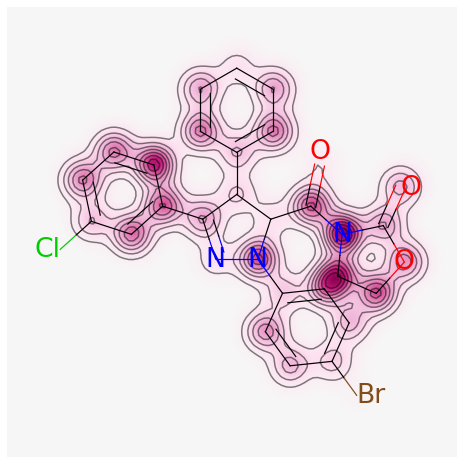

In [12]:
print('Generating maps with predicted fragment contribution for beta-lactamase...')
for i, mol in zip(range(len(moldf.Mol)), moldf.Mol):
    pred_frag(mol, beta_lactamase_model)
    plt.savefig('maps/mol_' + str(i) + '_beta-lactamase.png', bbox_inches='tight')

Generating maps with predicted fragment contribution for cruzain...


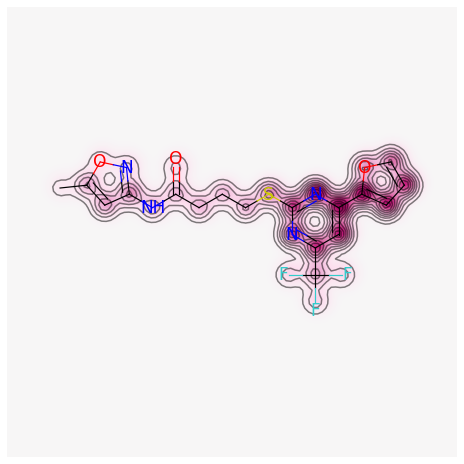

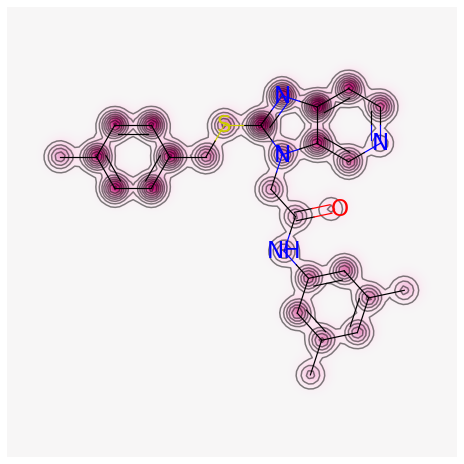

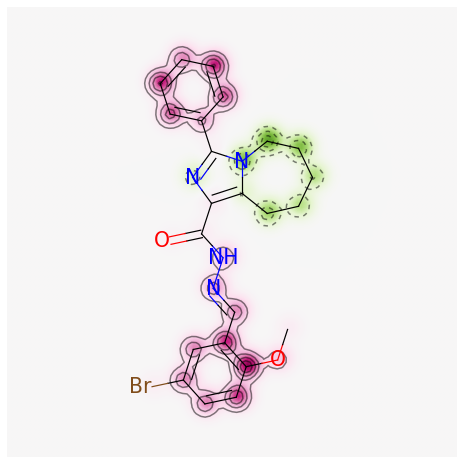

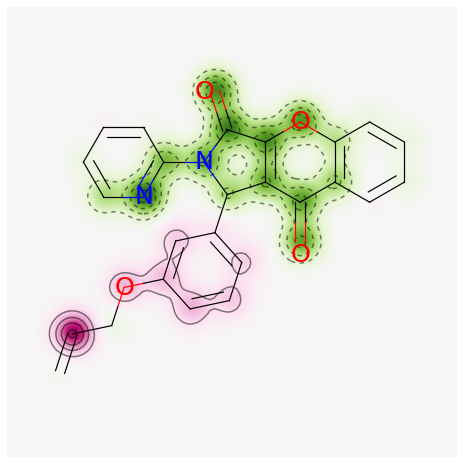

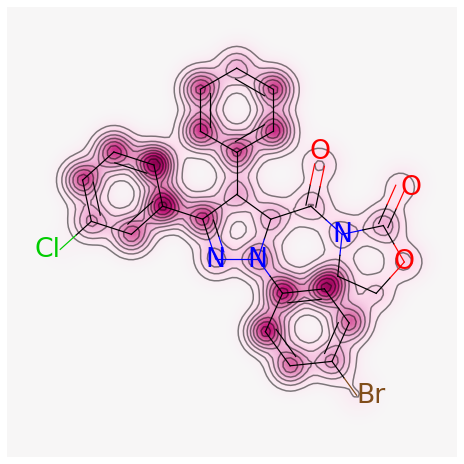

In [13]:
print('Generating maps with predicted fragment contribution for cruzain...')
for i, mol in zip(range(len(moldf.Mol)), moldf.Mol):
    pred_frag(mol, cruzain_model)
    plt.savefig('maps/mol_' + str(i) + '_cruzain.png', bbox_inches='tight')